In [1]:
import redis 
import math
import matplotlib.pyplot as plt


In [6]:
# Configuration
REDIS_HOST = 'bobby_redis'
REDIS_PORT = 6379
REDIS_DB = 0

In [7]:
STREAM_NAME = 'mystream'

In [8]:
"""Connect to Redis"""
r = redis.StrictRedis(host=REDIS_HOST, port=REDIS_PORT, db=REDIS_DB)

In [5]:
""" Single Value gets an sets"""
# Set
r.set('key', 'Hello Class')

# Get
value = r.get('key')
print(value.decode('utf-8'))

ConnectionError: Error 99 connecting to localhost:6379. Cannot assign requested address.

In [6]:
""" Lists """
# Add to tail (right)
r.rpush('listKey', 'VR1', 'VR2')

# Add to head (left)
r.lpush('listKey', 'VL1', 'VL2')

# Pop from tail (right)
r.rpop('listKey')

# Pop from head (left)
r.lpop('listKey')

# Get by index
value = r.lindex('listKey', 0)
print(value.decode('utf-8'))

VL1


In [7]:
""" Sets """
# Add
r.sadd('setKey', 'v1', 'v2')
r.sadd('setKey', 'v1', 'v2', 'v3', 'v4')
r.sadd('setKey', 'v5')

# Remove
r.srem('setKey', 'v1', 'v2')

# Check if exists
exists = r.sismember('setKey', 'v6')
print(exists)

# Get all members
members = r.smembers('setKey')
for member in members:
    print(member.decode('utf-8'))

0
v5
v4
v3


In [8]:
"""Sorted Sets """
score1 = 1
score2 = 3
minScore = 2
maxScore = 4
startIndex = 0
endIndex = 5

# Add
r.zadd('zsetKey', {'member1': score1, 'member2': score2})

# Get by score range
members_by_score = r.zrangebyscore('zsetKey', minScore, maxScore)
for member in members_by_score:
    print(member.decode('utf-8'))

# Get by rank range
members_by_rank = r.zrange('zsetKey', startIndex, endIndex)
for member in members_by_rank:
    print(member.decode('utf-8'))


member2
member1
member2


In [9]:
""" Hash Maps """
# Set field
r.hset('hashKey', mapping={'field1': 'value1', 'field2': 'value2'})

# Get field
value = r.hget('hashKey', 'field1')
print(value.decode('utf-8'))

# Get all fields and values
fields_values = r.hgetall('hashKey')
for field, value in fields_values.items():
    print(field.decode('utf-8'), ":", value.decode('utf-8'))

value1
field1 : value1
field2 : value2


In [10]:
""" Add points to a redis stream """
def add_sine_wave_to_stream(redis_conn, stream_name, points=1000, step=0.01):
    """Add sine wave points to a Redis stream."""
    
    for i in range(points):
        t = i * step
        y = math.sin(2 * math.pi * t)
        
        # Add the sine wave point to the stream
        redis_conn.xadd(stream_name, {"time": t, "value": y})


In [11]:
def plot_sine_wave_from_stream(redis_conn, stream_name):
    """Fetch sine wave points from a Redis stream and plot them."""

    # Fetch all the points from the stream
    # Note: In a production scenario, you may want to fetch in batches rather than all at once.
    entries = redis_conn.xrange(stream_name)

    times = []
    values = []

    for _, entry in entries:
        times.append(float(entry[b'time']))
        values.append(float(entry[b'value']))

    # Plotting
    plt.plot(times, values)
    plt.title("Sine Wave from Redis Stream")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

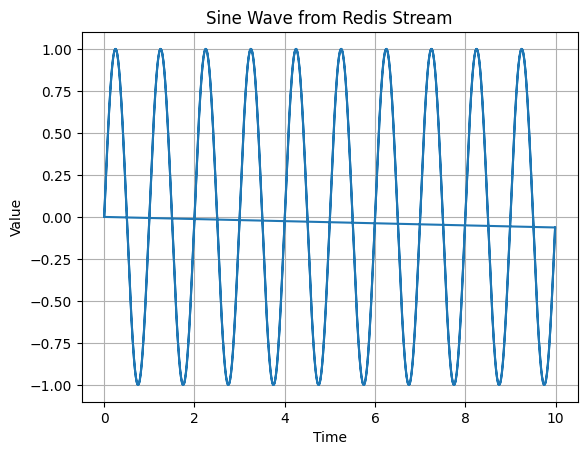

In [12]:
# Example usage:
add_sine_wave_to_stream(r, "sine_wave_stream")
plot_sine_wave_from_stream(r, "sine_wave_stream")

In [13]:
def add_sine_wave_to_streamTS(redis_conn, stream_name, points=1000, step=0.01):
    """Add sine wave points to a Redis stream without explicit time."""
    
    for i in range(points):
        y = math.sin(2 * math.pi * i * step)
        # Only store the sine value; Redis will automatically timestamp it
        redis_conn.xadd(stream_name, {"value": y}, maxlen=25000)

def plot_sine_wave_from_streamTS(redis_conn, stream_name):
    """Fetch sine wave points from a Redis stream and plot them using Redis timestamps."""

    entries = redis_conn.xrevrange(stream_name, count=2000)

    timestamps = []
    values = []

    for timestamp, entry in entries:
        # Convert Redis millisecond timestamp to seconds for plotting
        timestamps.append(float(timestamp.decode('utf-8').split('-')[0]) / 1000.0)
        values.append(float(entry[b'value']))

    plt.plot(timestamps, values)
    plt.title("Sine Wave from Redis Stream")
    plt.xlabel("Timestamp (seconds since epoch)")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

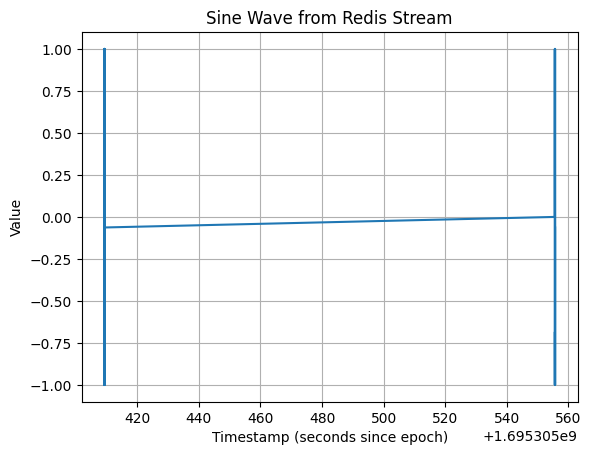

In [14]:
add_sine_wave_to_streamTS(r, "sine_wave_streamTS")
plot_sine_wave_from_streamTS(r, "sine_wave_streamTS")

In [15]:
"""Check the size of the stream"""
r.xlen("sine_wave_streamTS")

2000